In [21]:
import numpy as np
from helpers import load_data, R_earth, M_solar, G
import matplotlib.pyplot as plt

# All the imported units are in CGS 

In [7]:
# r in earth radius units
# log g is base10 logarithm of gravity at the shell in CGS
# mass is in solar units

length_unit = 1477*1e2 # cm
time_unit = 4.927*1e-6 # seconds

force_unit = M_solar*length_unit / time_unit**2

star_data = load_data("white_dwarf_data.csv")
star_data["logg"] = np.log10(pow(star_data["logg"],10)/force_unit)
star_data["r"] = star_data["r"]*R_earth / length_unit
star_data

,wdid,logg,mass,cgs_mass,r,id
368,SDSS J160420.40+055542.3,-39.289643,1.380,2.744820e+33,1565.234102,0
366,SDSS J114829.00+482731.2,-39.367772,1.319,2.623491e+33,1861.067632,1
372,WD 1253+385,-39.643456,1.088,2.164032e+33,3280.606989,2
363,SDSS J091145.12+353135.6,-39.659793,1.069,2.126241e+33,3377.758618,3
360,SDSS J012339.94+405241.9,-39.708173,1.011,2.010879e+33,3672.952703,4
...,...,...,...,...,...,...
132,Gaia DR2 2521858084423378176,-40.764792,0.115,2.287350e+32,10665.683162,373
135,Gaia DR2 256087115787263616,-40.865095,0.084,1.670760e+32,10896.308763,374
348,Gaia DR2 740483560857296768,-40.910503,0.074,1.471860e+32,11072.753146,375
361,SDSS J013441.30-092212.7,-40.901251,0.077,1.531530e+32,11114.376915,376


In [18]:
from math import pi

def Rho(P):
    return np.sqrt(P/K_ns)

def RHS(r, vec):
    """
    :param r: radius 
    :param vec: (m, nu, P)
    :return: D(vec)/Dr vector
    """
    m,nu,P = vec[:]
    rho = Rho(P)
    
    dmdr = 4*pi*(r**2)*rho
    
    dnudr = 2*(m + 4*pi*(r**3)*P) / (r*(r-2*m*r)) if r != 0 else 0
    
    dPdr = (-1/2)*(rho + P)*dnudr
    
    return np.array([dmdr, dnudr, dPdr])


def RK4(r, vec, dx):
    assert (not np.any(np.isnan(vec))) or (not np.any(np.isinf(vec)))
    
    k1 = dx*RHS(r, vec)
    k2 = dx*RHS(r+0.5*dx, vec + 0.5*k1)
    k3 = dx*RHS(r+0.5*dx, vec + 0.5*k2)
    k4 = dx*RHS(r+dx,vec + k3)

    vec += (k1 + 2*k2 + 2*k3 + k4)/6
    return vec
    
    
def integrate_TOV(rho_c, K_ns, tol=1e-8, dx=1e-4):
    vec0 = np.array([0, 0, K_ns*rho_c**2],dtype=float)
    vec_array = []
    r0 = 0
    
    while abs(vec0[-1]) > tol:
        vec0 = RK4(r0, vec0, dx)[:]
        r0 += dx
        
        vec_array.append(vec0)
        
    return np.array(vec_array), r0

    

In [46]:
from scipy.integrate import solve_ivp

K_ns = 100
rho_vec = np.logspace(-4,0,40)
print("Total rho vals:", len(rho_vec))

M_R_data = []

for i,rho_c in enumerate(rho_vec):
    print("Integration ", i+1)
    data, R = integrate_TOV(rho_c, K_ns)
    M = data[-1,0]
    
    M_R_data.append([R,M])
    
M_R_data = np.array(M_R_data)




Total rho vals: 40
Integration  1
Integration  2
Integration  3
Integration  4
Integration  5
Integration  6
Integration  7
Integration  8
Integration  9
Integration  10
Integration  11
Integration  12
Integration  13
Integration  14
Integration  15
Integration  16
Integration  17
Integration  18
Integration  19
Integration  20
Integration  21
Integration  22
Integration  23
Integration  24
Integration  25
Integration  26
Integration  27
Integration  28
Integration  29
Integration  30
Integration  31
Integration  32
Integration  33
Integration  34
Integration  35
Integration  36
Integration  37
Integration  38
Integration  39
Integration  40


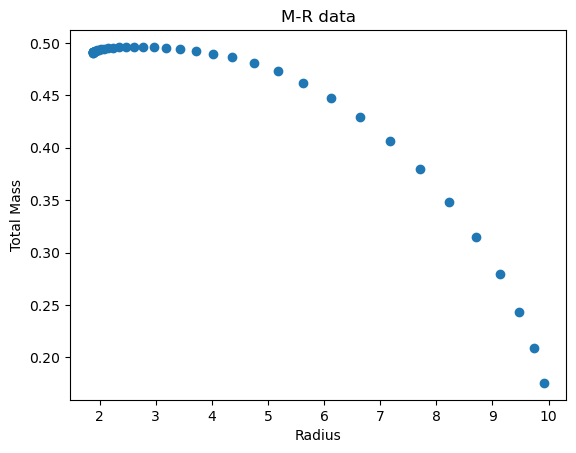

In [52]:
plt.scatter(M_R_data[:,0], M_R_data[:,1])
plt.title("M-R data")
plt.xlabel("Radius")
plt.ylabel("Total Mass")
plt.show()

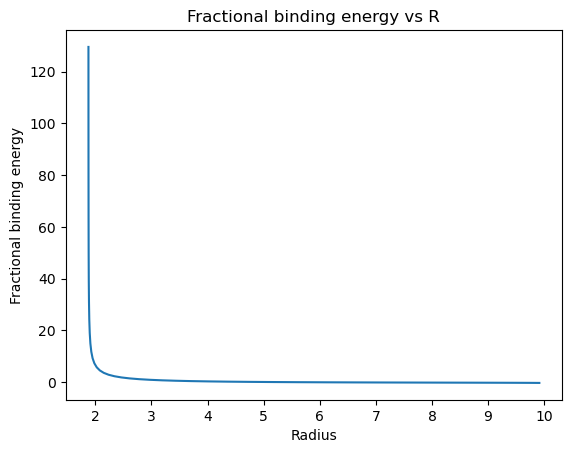

In [51]:
# Calculate binding energy

M_vec = M_R_data[:,1]
R_vec = M_R_data[:,0]

Mp_vec = 4*pi*((1-2*M_vec/R_vec)**(-1/2))*(R_vec**2)*rho_vec
delta_vec = (Mp_vec - M_vec) / M_vec

plt.plot(R_vec, delta_vec)
plt.title("Fractional binding energy vs R")
plt.xlabel("Radius")
plt.ylabel("Fractional binding energy")
plt.show()


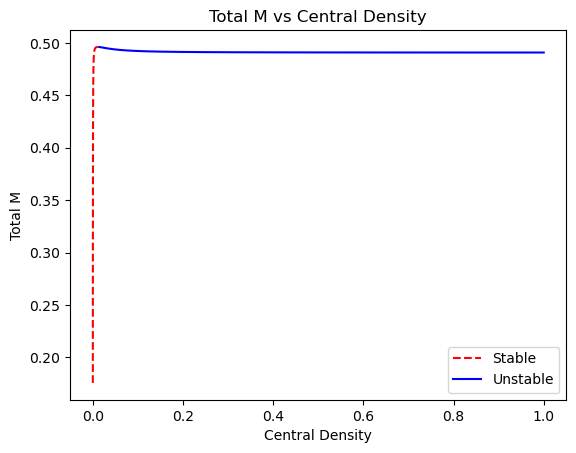

Max stable mass: 0.49610215355588083


In [71]:
# Plot stable and unstable regions
Mdiff_vec = M_vec[1:]-M_vec[:-1]

sign_change_index = [np.sign(Mdiff_vec[i]*Mdiff_vec[i+1]) for i in range(len(Mdiff_vec)-1)].index(-1)

stable_region = M_vec[:sign_change_index+2]
max_stable_M = stable_region[-1]
unstable_region = M_vec[sign_change_index+2:]

plt.title("Total M vs Central Density")
plt.xlabel("Central Density")
plt.ylabel("Total M")
plt.plot(rho_vec[:len(stable_region)], stable_region, "--", c="r", label="Stable")
plt.plot(rho_vec[len(stable_region):], unstable_region, "-", c="b", label="Unstable")
plt.legend()
plt.show()
print("Max stable mass:", max_stable_M)


### Plotting K versus maximal M

We converted all the code above into a procedure that takes K_ns as an input

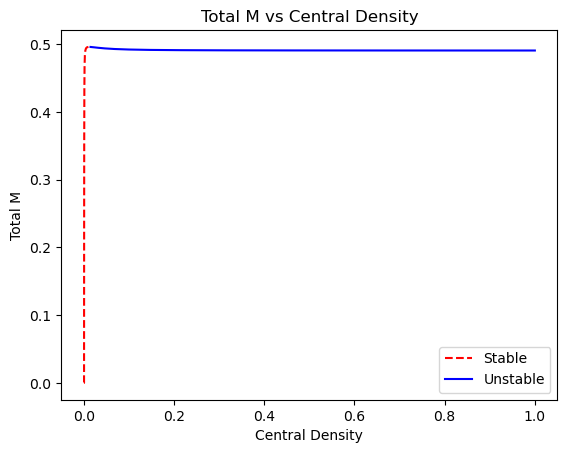

Max stable mass: 0.49599835619939825


In [73]:

# Function Definitions
def Rho(P, K_ns):
    return np.sqrt(P / K_ns)

def RHS(r, vec, K_ns):
    m, nu, P = vec
    rho = Rho(P, K_ns)
    
    dmdr = 4 * pi * (r**2) * rho
    dnudr = 2 * (m + 4 * pi * (r**3) * P) / (r * (r - 2 * m * r)) if r != 0 else 0
    dPdr = (-1 / 2) * (rho + P) * dnudr
    
    return np.array([dmdr, dnudr, dPdr])

def RK4(r, vec, dx, K_ns):
    k1 = dx * RHS(r, vec, K_ns)
    k2 = dx * RHS(r + 0.5 * dx, vec + 0.5 * k1, K_ns)
    k3 = dx * RHS(r + 0.5 * dx, vec + 0.5 * k2, K_ns)
    k4 = dx * RHS(r + dx, vec + k3, K_ns)

    return vec + (k1 + 2 * k2 + 2 * k3 + k4) / 6

def integrate_TOV(rho_c, K_ns, tol=1e-5, dx=1e-3):
    vec0 = np.array([0, 0, K_ns * rho_c**2], dtype=float)
    r0 = 0
    
    while abs(vec0[-1]) > tol:
        vec0 = RK4(r0, vec0, dx, K_ns)
        r0 += dx
    
    return vec0[0], r0

def find_max_stable_mass(K_ns):
    rho_vec = np.logspace(-4, 0, 25)
    M_R_data = []
    
    for rho_c in rho_vec:
        M, R = integrate_TOV(rho_c, K_ns)
        M_R_data.append([R, M])
    
    M_R_data = np.array(M_R_data)
    M_vec = M_R_data[:, 1]
    
    # Identify stable and unstable regions
    Mdiff_vec = M_vec[1:] - M_vec[:-1]
    sign_change_index = next(i for i in range(len(Mdiff_vec) - 1) if np.sign(Mdiff_vec[i] * Mdiff_vec[i + 1]) == -1)
    
    max_stable_M = M_vec[sign_change_index + 1]

    # Optional: Plotting
    plt.title("Total M vs Central Density")
    plt.xlabel("Central Density")
    plt.ylabel("Total M")
    plt.plot(rho_vec[:sign_change_index + 2], M_vec[:sign_change_index + 2], "--", c="r", label="Stable")
    plt.plot(rho_vec[sign_change_index + 2:], M_vec[sign_change_index + 2:], "-", c="b", label="Unstable")
    plt.legend()
    plt.show()

    return max_stable_M

# Example usage
max_stable_mass = find_max_stable_mass(K_ns=100)
print("Max stable mass:", max_stable_mass)


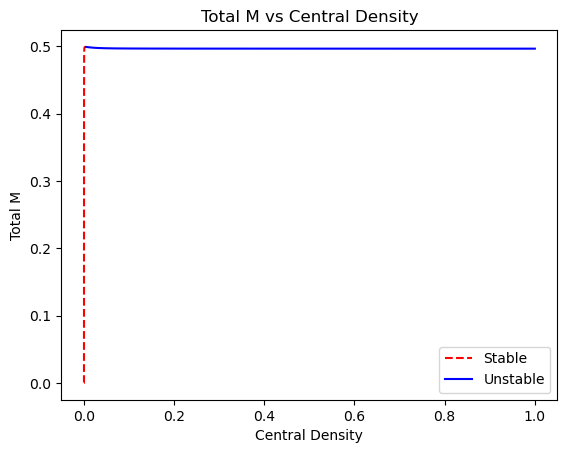

Max stable mass: 0.49937187285460816


In [78]:
max_stable_mass = find_max_stable_mass(K_ns=300)
print("Max stable mass:", max_stable_mass)